# Final Project 
### Madeline Carter, Ethan Crow, Alex Isbill

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, LabelEncoder, label_binarize, OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

## Gathering the Data 
- To create dataset, pull data using the Spotipy Library to access the Spotify API.
- 1,000 songs from each of the following genres were pulled: **Pop, Rock, Country, EDM, Rap, and Classical**
- For each song, features such as "danceability", "energy", "loudness", "speechiness", and "acousticness" are recorded into a dataframe.
- Dataframe is saved to csv so that it can be loaded directly.

In [48]:
# Spotify Client ID needed for API
cid = 'e21fac1ac27b472bb579f569fab7f167'
secret = 'febd3a4f0dc34c1099ce2939aefec727'
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)

sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [ ]:
# Create dictionary of features that will be pulled from each song
features = {
            "genre" : [],
            "artist_name": [],
            "track_name": [],
            "track_id": [],
            "popularity": [],
            "danceability": [],
            "energy": [],
            "key": [],
            'loudness': [],
            'mode': [],
            'speechiness': [],
            'acousticness': [],
            'instrumentalness': [],
            'liveness': [],
            'valence': [],
            'tempo': [],
            'duration_ms': []
            }

genres = ['pop', 'rock', 'country', 'EDM', 'rap', 'classical']

# Search Spotify by genre and add feature values of each song to the features dictionary
for genre in genres:
    genreS = "genre:" + genre
    for i in range (0,1000,50):
        results = sp.search(q=genreS, type='track', limit=50,offset=i)

        for track in results['tracks']['items']:
            features['artist_name'].append(track['artists'][0]['name'])
            features['track_name'].append(track['name'])
            features['track_id'].append(track['id'])
            features['popularity'].append(track['popularity'])
            features['genre'].append(genre)
            audio_features = sp.audio_features(track['id'])
            features['danceability'].append(audio_features[0]["danceability"])
            features['energy'].append(audio_features[0]["energy"])
            features['key'].append(audio_features[0]["key"])
            features['loudness'].append(audio_features[0]["loudness"])
            features['mode'].append(audio_features[0]["mode"])
            features['speechiness'].append(audio_features[0]["speechiness"])
            features['acousticness'].append(audio_features[0]["acousticness"])
            features['instrumentalness'].append(audio_features[0]["instrumentalness"])
            features['liveness'].append(audio_features[0]["liveness"])
            features['valence'].append(audio_features[0]["valence"])
            features['tempo'].append(audio_features[0]["tempo"])
            features['duration_ms'].append(audio_features[0]["duration_ms"])
            
# Create a dataframe from the dictionary values           
class_df = pd.DataFrame.from_dict(features)

In [ ]:
class_df.drop_duplicates(subset = ["track_id"], inplace=True)

In [104]:
# Save as csv to avoid pulling the data again
#class_df.to_csv("class_data.csv", index=False)

## Exploratory Data Analysis

- Observe patterns in potential predictor variables by using `df.corr()` to look at correlation between every numeric feature.

- **Acousticness** and **Instrumentalness** are highly correlated.

- **Energy**, **loudness**, and **popularity**, and to a lesser extent **danceability**, are all positively correlated. 
    - These four features are very strongly *negatively* correlated to the two features mentioned above. 

<AxesSubplot:>

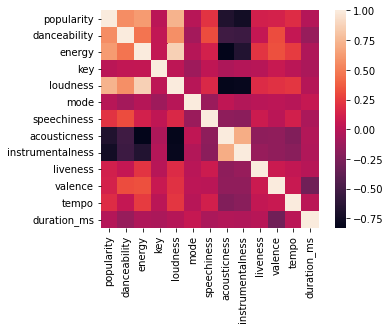

In [2]:
data = pd.read_csv("class_data.csv")
non_numerics = ["genre", "artist_name", "track_name", "track_id"]

sns.heatmap(data.drop(columns=non_numerics).corr(), square=True)

In [3]:
data.drop(columns=non_numerics).corr()

popularity  danceability    energy       key  loudness  \
popularity          1.000000      0.566782  0.627818  0.006825  0.732033   
danceability        0.566782      1.000000  0.464818  0.035819  0.576125   
energy              0.627818      0.464818  1.000000  0.046351  0.868503   
key                 0.006825      0.035819  0.046351  1.000000  0.022745   
loudness            0.732033      0.576125  0.868503  0.022745  1.000000   
mode               -0.001868     -0.082975 -0.014555 -0.112017 -0.002162   
speechiness         0.218720      0.318738  0.122490  0.030248  0.165963   
acousticness       -0.677459     -0.529890 -0.830436 -0.045709 -0.809551   
instrumentalness   -0.738437     -0.544162 -0.659511 -0.017691 -0.797747   
liveness            0.114507      0.055548  0.221310 -0.004680  0.177848   
valence             0.129595      0.314671  0.332571  0.064367  0.209161   
tempo               0.187734      0.052526  0.252028  0.006747  0.234382   
duration_ms        -0.020565     -0.139442 -0.037596 -0.055325 -0.012475   

                      mode  speechiness  acousticness  instrumentalness  \
popularity       -0.001868     0.218720     -0.677459         -0.738437   
danceability     -0.082975     0.318738     -0.529890         -0.544162   
energy           -0.014555     0.122490     -0.830436         -0.659511   
key              -0.112017     0.030248     -0.045709         -0.017691   
loudness         -0.002162     0.165963     -0.809551         -0.797747   
mode              1.000000    -0.124839      0.031478         -0.023509   
speechiness      -0.124839     1.000000     -0.178455         -0.188198   
acousticness      0.031478    -0.178455      1.000000          0.700763   
instrumentalness -0.023509    -0.188198      0.700763          1.000000   
liveness          0.002781     0.085820     -0.174206         -0.141214   
valence           0.017318     0.012712     -0.171616         -0.165731   
tempo            -0.001723     0.116978     -0.233501         -0.196739   
duration_ms       0.061608    -0.051882     -0.024689         -0.035060   

                  liveness   valence     tempo  duration_ms  
popularity        0.114507  0.129595  0.187734    -0.020565  
danceability      0.055548  0.314671  0.052526    -0.139442  
energy            0.221310  0.332571  0.252028    -0.037596  
key              -0.004680  0.064367  0.006747    -0.055325  
loudness          0.177848  0.209161  0.234382    -0.012475  
mode              0.002781  0.017318 -0.001723     0.061608  
speechiness       0.085820  0.012712  0.116978    -0.051882  
acousticness     -0.174206 -0.171616 -0.233501    -0.024689  
instrumentalness -0.141214 -0.165731 -0.196739    -0.035060  
liveness          1.000000  0.081156  0.043261    -0.008030  
valence           0.081156  1.000000  0.074114    -0.301880  
tempo             0.043261  0.074114  1.000000     0.010687  
duration_ms      -0.008030 -0.301880  0.010687     1.000000

- Observe how these features are represented in each genre by first converting them to z-scores, then taking the mean from each genre.

In [4]:
scaler = StandardScaler()
cols = data.drop(columns=["artist_name", "track_name", "track_id", "genre"]).columns
data_s = scaler.fit_transform(data[cols])

data_s = pd.DataFrame(data_s, columns=cols)
data_s["genre"] = data["genre"]
data_s

popularity  danceability    energy       key  loudness      mode  \
0       1.555768      0.171551 -0.803436 -0.063293  0.266155  0.696587   
1       1.323476      0.325102 -0.225806 -1.468319  0.096327  0.696587   
2       1.400906      0.922247  0.481031 -0.625303  0.281076 -1.435571   
3       1.284760      0.512777  0.120012 -1.187314  0.403157  0.696587   
4       1.323476     -0.061620  0.329023  1.060728  0.601878  0.696587   
...          ...           ...       ...       ...       ...       ...   
5376   -2.199627     -1.193352 -1.476071  0.498718 -2.170313 -1.435571   
5377   -2.315773     -1.159230 -1.289862  0.217712 -1.259995  0.696587   
5378   -2.199627     -1.898552 -1.700283  1.622739 -3.071950 -1.435571   
5379   -2.315773     -0.391472 -1.514073  0.217712 -1.581882  0.696587   
5380   -2.160911     -0.522275 -1.335464 -1.468319 -2.315861 -1.435571   

      speechiness  acousticness  instrumentalness  liveness   valence  \
0       -0.617074      0.693388         -0.480856 -0.287173 -1.439584   
1       -0.592257     -0.155814         -0.480856 -0.644194 -1.128688   
2       -0.223538     -0.864506         -0.480856 -0.944885  1.727403   
3       -0.114814     -0.072011         -0.480856 -0.607698 -1.174286   
4        0.869617      0.014585         -0.480856 -0.668789  0.873477   
...           ...           ...               ...       ...       ...   
5376    -0.448078      1.858247          2.264108 -0.453783  0.334592   
5377    -0.548531      1.754890          0.758805 -0.191967  0.558437   
5378    -0.391353      1.855453          2.172508 -0.501385  0.703521   
5379    -0.411443      1.562143         -0.451819  0.664882  1.719112   
5380    -0.446897      1.855453          2.358762 -0.469650  2.013426   

         tempo  duration_ms      genre  
0     0.760887     0.144255        pop  
1    -0.902550     4.961569        pop  
2     1.033177    -0.013228        pop  
3     0.355203    -0.031092        pop  
4     1.608506    -0.433180        pop  
...        ...          ...        ...  
5376  0.153381    -0.917812  classical  
5377 -1.260666    -1.888725  classical  
5378  1.553158    -0.826671  classical  
5379  0.278722    -0.885397  classical  
5380 -0.266334    -1.068658  classical  

[5381 rows x 14 columns]

In [5]:
genres = data_s.groupby(by="genre").mean()
genres

popularity  danceability    energy       key  loudness      mode  \
genre                                                                         
EDM          0.060300      0.387359  0.666716  0.070353  0.577791 -0.224470   
classical   -1.835379     -1.362961 -1.656521 -0.036363 -1.899797 -0.025237   
country      0.209234      0.015666  0.362959  0.059470  0.420129  0.435451   
pop          0.675138      0.348609  0.148709 -0.035390  0.375745 -0.060468   
rap          0.584559      0.877770  0.126725  0.028602  0.369510 -0.218734   
rock         0.458493     -0.136544  0.469920 -0.076750  0.304881  0.147137   

           speechiness  acousticness  instrumentalness  liveness   valence  \
genre                                                                        
EDM          -0.066395     -0.600795         -0.264426  0.116209 -0.169319   
classical    -0.423049      1.726306          1.850848 -0.325292 -0.335888   
country      -0.442769     -0.221460         -0.472764  0.047553  0.270228   
pop           0.067536     -0.213464         -0.428264 -0.002927  0.033128   
rap           1.312153     -0.396765         -0.467261  0.145151 -0.112206   
rock         -0.325907     -0.428996         -0.399879  0.057773  0.373232   

              tempo  duration_ms  
genre                             
EDM        0.136152    -0.109011  
classical -0.499357    -0.050742  
country    0.113368    -0.042182  
pop        0.027102     0.024167  
rap        0.146294    -0.105174  
rock       0.131807     0.280845

- Establish one of these genres, **Rock**, as a base level. 
- Identify and interpret the difference between Rock and the other genres.

In [6]:
for genre in genres.index:
    genres.loc[genre] = genres.loc[genre] - genres.iloc[5]

genres

popularity  danceability    energy       key  loudness      mode  \
genre                                                                         
EDM         -0.398193      0.523904  0.196796  0.147103  0.272910 -0.371607   
classical   -2.293872     -1.226416 -2.126441  0.040387 -2.204678 -0.172374   
country     -0.249259      0.152210 -0.106961  0.136220  0.115248  0.288315   
pop          0.216645      0.485154 -0.321211  0.041361  0.070864 -0.207605   
rap          0.126066      1.014315 -0.343195  0.105352  0.064630 -0.365870   
rock         0.000000      0.000000  0.000000  0.000000  0.000000  0.000000   

           speechiness  acousticness  instrumentalness  liveness   valence  \
genre                                                                        
EDM           0.259512     -0.171799          0.135453  0.058436 -0.542551   
classical    -0.097142      2.155302          2.250727 -0.383065 -0.709120   
country      -0.116863      0.207536         -0.072885 -0.010220 -0.103004   
pop           0.393443      0.215533         -0.028385 -0.060700 -0.340104   
rap           1.638060      0.032232         -0.067382  0.087377 -0.485438   
rock          0.000000      0.000000          0.000000  0.000000  0.000000   

              tempo  duration_ms  
genre                             
EDM        0.004345    -0.389856  
classical -0.631164    -0.331587  
country   -0.018439    -0.323027  
pop       -0.104705    -0.256678  
rap        0.014487    -0.386019  
rock       0.000000     0.000000

* *Classical music* has the most differences between the rest of the genres by far-- the magnitude of its bars tells that much. 
* In contrast, the small bars of *country* mean it will likely be difficult to differentiate rock and country. It looks like duration or acousticness will be the most useful in telling them apart. 
* *Rap* is set apart from every other genre by its high speechiness and danceability. 
* *Pop's* defining traits appear to be danceability and speechiness as well, though not to the same extent as rap. It also has the highest popularity of the genres.
* *EDM* has the highest instrumentalness after classical music, the highest loudness and energy, and much lower popularity than the other genres. 
* Other differences are not quite as obvious: we must keep these observations in mind while training the classifier.

Text(0.5, 1.0, 'Z-scores of Rock vs other Genres')

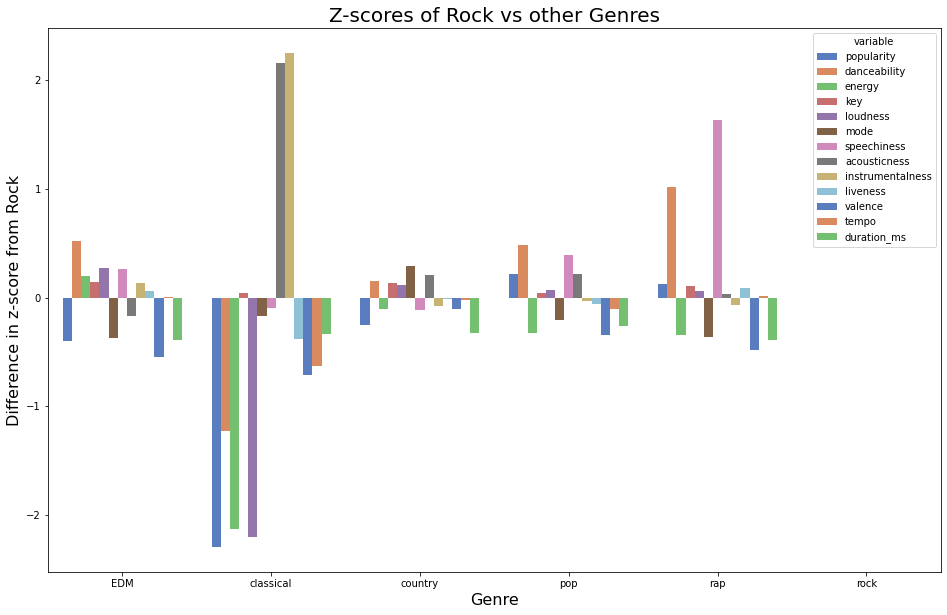

In [7]:
plt.figure(figsize=(16, 10))

sns.barplot(data=genres.reset_index().melt("genre"), x="genre", y="value", hue="variable", palette="muted")
plt.ylabel("Difference in z-score from Rock", size=16)
plt.xlabel("Genre", size=16)
plt.title("Z-scores of Rock vs other Genres", size=20)

In the process of our model creation, we found that pop was regularly confused for other genres, to the point of unusability. We decided to remove pop songs from our genre classifier for that reason. Why, specifically, is that the case? Let's look at a comparison of its Z-scores against the other genres, like we did for rock.

In [11]:
genres = data_s.groupby(by="genre").mean()

pop = genres.loc["pop"]

genres = genres - pop

Text(0.5, 1.0, 'Z-scores of Pop vs other Genres')

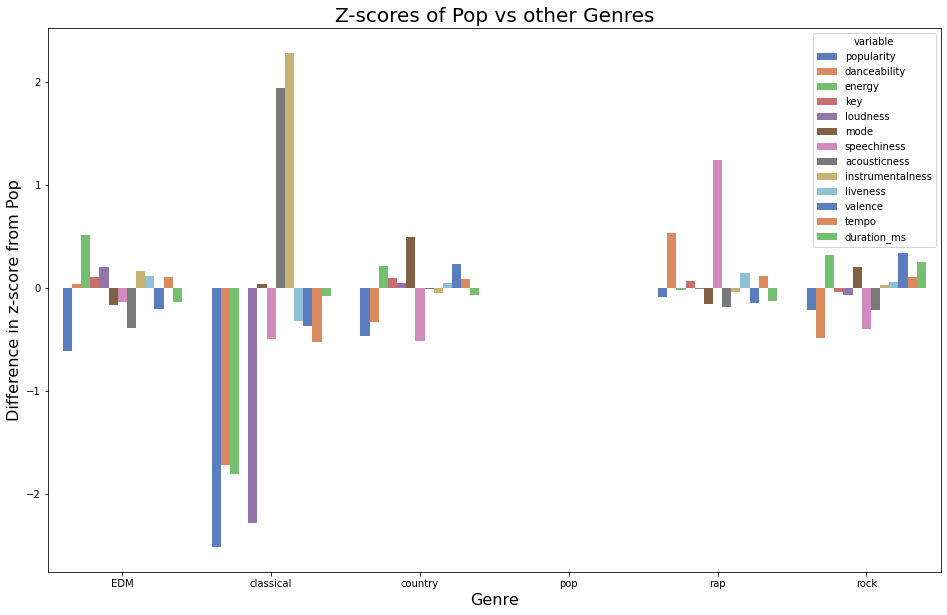

In [9]:
plt.figure(figsize=(16, 10))

sns.barplot(data=genres.reset_index().melt("genre"), x="genre", y="value", hue="variable", palette="muted")
plt.ylabel("Difference in z-score from Pop", size=16)
plt.xlabel("Genre", size=16)
plt.title("Z-scores of Pop vs other Genres", size=20)

Let's break down the differences between pop's characteristics and those of the other genres, excluding classical from most of this discussion due to its massive differences.
* Pop has the highest popularity, but rap is only slightly lower.
* Pop's danceability is middle-of-the-road, higher than some and lower than others.
* A similar story with energy, though pop's energy may be on the lower end.
* Key is mostly irrelevant in our opinion. The differences are very small.
* Pop's loudness also does not differ very much from most of the genres.
* Except for country, the mode (major/minor) of pop also does not differ much from the others.
* Pop's speechiness is rather high, except when compared to rap.
* Acousticness is slightly higher than the others, but not significantly.
* Instrumentalness varies very little by genre (except classical, of course).
* Liveness appears to be on the lower end, but not by much.
* Valence also seems to be middle of the road.
* Tempo is slightly lower than the others.
* With the exception of rock, duration is on the higher end.

Almost all of pop's characteristics land in the middle of the other genres, or only set themselves apart by a small margin. This makes it especially hard for a classifier such as ours to make distinctions between pop and other genres. Rock and country are a similar story, but they have some identifying traits which differ intensely from the others, such as tempo. 

-------------------------

## Creating a Genre Classifier
- The goal of the classifier is to **predict the genre of a given song**.
- The **features** used to predict genre include:
    - Danceability, energy, loudness, speechiness, acousticness, instrumentalness, liveness, valence, tempo, and duration of a song.
- All features are scaled using `MinMaxScaler()` to be used in the classification models
- Y labels are encoded to numerical format using `LabelEncoder()`

In [105]:
# Pop is removed for classification as it contains overlap with other genres
data = data[data["genre"] != "pop"]
data['genre'].value_counts()

EDM          963
classical    960
rock         877
country      792
rap          792
Name: genre, dtype: int64

In [106]:
features = ['danceability', 'energy', 'loudness', 'speechiness', 
           'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', "duration_ms"]

genres = ['rock','country', 'EDM','rap', 'classical']

le = LabelEncoder()

# Transform y labels into numerical categories using LabelEncoder()
X = data[features]
y = le.fit_transform(data['genre'])
le.transform(['rock','country', 'EDM','rap', 'classical'])

genres_re = ["EDM","classical","country","rap","rock"]

In [108]:
# Create train, validation, and test sets in a 70%, 20%, 10% split
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = .9, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=.77, random_state=1)

In [109]:
# Scale all x dataframes to be used with classifier
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), columns = X.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns = X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X.columns)

### Evaluation Environment
- The evaluation environment takes as input:
    - Model Name
    - Set being evaluated (training, validation, or test)
    - The ground-truth y-labels for the set.
    - The predicted labels for the set.
- The evaluation environment returns:
    - Accuracy
    - F1 Score
    - Confusion Matrix

In [113]:
# Evaluation environment
# Return accuracy, F1 score, and Confusion Matrix for given model
def evalEnv(model, set_type, y_label, y_pred, cm = False):
    
    print("\nModel: " + model)
    print("\n" + set_type + " Accuracy = " + str(accuracy_score(y_label, y_pred)))
    print(set_type + " F1 Score = " + str(f1_score(y_label, y_pred, average= "weighted")))
    
    #Plot Confusion Matrix
    if cm:
        cm = confusion_matrix(y_label, y_pred)
        fig, ax = plt.subplots(figsize=(8,8))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title(model + " Confusion Matrix")
        plt.colorbar()
        tick_marks = np.arange(len(genres))
        plt.xticks(tick_marks, genres_re, rotation=45)
        plt.yticks(tick_marks, genres_re)
        # Plot numbers onto grid
        for (j,i),label in np.ndenumerate(cm):
            ax.text(i,j,label,ha='center',va='center')

In [114]:
# Runs model on training set and returns predictions for the set given by the last parameter
def runModel(model, X_tr, y_tr, X_v):
    model.fit(X_tr,y_tr)
    y_pred = model.predict(X_v)
    return y_pred

### Testing Models
- Using the evaluation environment, we can quickly test a variety of classifier models to see which performs best.
- Two baselines are created to compare results with.
    - **Baseline 1**: Randomly guess one of the five genres
    - **Baseline 2**: Guess the most common genre in the dataset (EDM)

In [97]:
models = {  "Nearest Neighbors": KNeighborsClassifier(),
            "Logistic Regression": LogisticRegression(max_iter=500),
            "Linear SVM": SVC(),
            "Decision Tree": DecisionTreeClassifier(),
            "Random Forest": RandomForestClassifier(),
            "Neural Network": MLPClassifier(max_iter=1000),
            "Naive Bayes": GaussianNB(),}

for modelName in models:
    preds = runModel(models[modelName], X_train, y_train, X_val)
    evalEnv(modelName, "Validation Set", y_val, preds)

baseline_rand = np.random.randint(0,5,len(y_val))
baseline_mode = np.zeros(len(y_val))

evalEnv("Random Guess Baseline", "", y_val, baseline_rand)
evalEnv("Guess Mode Baseline", "", y_val, baseline_mode)


Model: Nearest Neighbors

Validation Set Accuracy = 0.6674008810572687
Validation Set F1 Score = 0.6662927905445358

Model: Logistic Regression

Validation Set Accuracy = 0.7224669603524229
Validation Set F1 Score = 0.720122998253079

Model: Linear SVM

Validation Set Accuracy = 0.7411894273127754
Validation Set F1 Score = 0.7412561871736524

Model: Decision Tree

Validation Set Accuracy = 0.6541850220264317
Validation Set F1 Score = 0.6535016515260214

Model: Random Forest

Validation Set Accuracy = 0.7610132158590308
Validation Set F1 Score = 0.7602809615433038

Model: Neural Network

Validation Set Accuracy = 0.7533039647577092
Validation Set F1 Score = 0.7528988782522831

Model: Naive Bayes

Validation Set Accuracy = 0.6101321585903083
Validation Set F1 Score = 0.5889812761420962

Model: Random Guess Baseline

 Accuracy = 0.20814977973568283
 F1 Score = 0.20985325136597968

Model: Guess Mode Baseline

 Accuracy = 0.23127753303964757
 F1 Score = 0.08688422529217531


### Preliminary Results
- All classifiers greatly outperform the baseline results.
- The top classifiers are Random Forest, Neural Network, and Liner SVM.


**Random Forest Classifier**

- The Random Forest Classifier performs the best of any classifier when given default parameters, with an accuracy in the 75-76 percent range over multiple runs.
- The confusion matrix gives us information about which genres the classifier performed well and poorly on.
    - Nearly all classical songs were classified correctly
    - Rock and country were the most commonly confused genres
    - EDM was often classified as country, rap, or rock


Model: Random Forest Classifier

Validation Set Accuracy = 0.7577092511013216
Validation Set F1 Score = 0.757345033863749


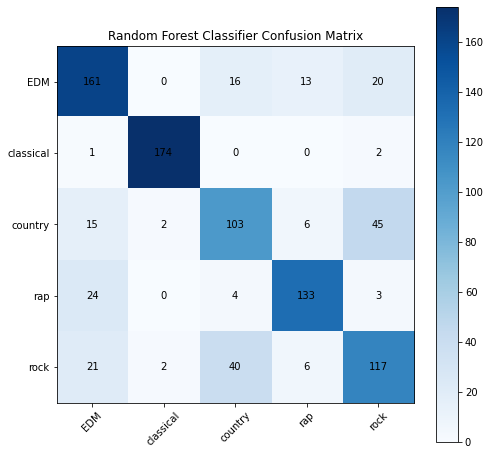

In [100]:
rf = RandomForestClassifier()

rf_pred_val = runModel(rf, X_train, y_train, X_val)

evalEnv("Random Forest Classifier", "Validation Set", y_val, rf_pred_val, cm = True)

### Hyperparameter Tuning
- Since the Random Forest Classifier performed the best of any classifier with default hyperparameters, we can now tune hyperparameters to see if we can improve performance.
- There are 18 hyperparameters for the classifier, so we can take a subset of the most important ones and test various values.
- This is done using `RandomizedSearchCV`
- From the results, we see that the model performs better with a greater number of n_estimators and max_depth. The tradeoff is that the model takes longer to train with more estimators.

In [25]:
parameters = {  'n_estimators': [100, 500, 1000],
                'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
                'max_features': ['auto', 'sqrt'],
                'min_samples_leaf': [1, 2, 4],
                'min_samples_split': [2, 5, 10] }
grid1 = RandomizedSearchCV(rf, parameters, cv=3, n_iter=20, random_state=42)
grid1.fit(X_train, y_train)
results1 = grid1.cv_results_
df1 = pd.DataFrame(results)
bestParams1 = df[["param_n_estimators", "param_max_depth", "param_max_features", "param_min_samples_leaf", "param_min_samples_split", 'mean_test_score']]
bestParams1

param_n_estimators param_max_depth param_max_features  \
0                 100              10               sqrt   
1                1000              60               sqrt   
2                 100              40               auto   
3                 100              40               sqrt   
4                 100              70               sqrt   
5                 500              50               sqrt   
6                1000              90               sqrt   
7                1000            None               auto   
8                 500              20               auto   
9                 500              40               sqrt   
10               1000              30               sqrt   
11               1000              10               sqrt   
12               1000              70               sqrt   
13               1000              70               sqrt   
14               1000              20               sqrt   
15               1000              60               sqrt   
16                500             100               auto   
17                500              80               sqrt   
18                500              20               sqrt   
19                500              50               auto   

   param_min_samples_leaf param_min_samples_split  mean_test_score  
0                       1                       5         0.739876  
1                       1                       2         0.750740  
2                       2                      10         0.744155  
3                       2                      10         0.740532  
4                       1                       5         0.739874  
5                       4                       5         0.744484  
6                       1                       5         0.752387  
7                       2                       2         0.745800  
8                       1                       2         0.752057  
9                       1                      10         0.745801  
10                      1                       2         0.751399  
11                      1                       2         0.743166  
12                      1                       2         0.748765  
13                      2                      10         0.748766  
14                      4                       2         0.744815  
15                      4                       5         0.744155  
16                      2                      10         0.746130  
17                      1                       5         0.749423  
18                      1                       2         0.746789  
19                      4                       2         0.745473

### Grid Search CV
- After finding the best values for the n_estimators and max_depth parameters, we use `GridSearchCV` to test values for the other parameters.
- This has an advantage over `RandomizedSearchCV` as it tests all possible values so that we can see exactly which parameters perform best.
- Note: Random Forest Classifier performs slightly differently on each run but the GridSearch takes the mean score over all cross validation sets, so it still should return the model with the best parameters.

In [100]:
parameters = {  'max_features' : ['auto', 'sqrt', 1],
                'min_samples_split' : [2, 5, 10, 15],
                'min_samples_leaf' : [1, 2, 5, 10] }
base = RandomForestClassifier(n_estimators = 1000, max_depth = 90)
grid = GridSearchCV(base, parameters, cv=3)
grid.fit(X_train, y_train)
results = grid.cv_results_
df = pd.DataFrame(results)
bestParams = df[["param_max_features", "param_min_samples_leaf", "param_min_samples_split", 'mean_test_score']]
bestParams

param_max_features param_min_samples_leaf param_min_samples_split  \
0                auto                      1                       2   
1                auto                      1                       5   
2                auto                      1                      10   
3                auto                      1                      15   
4                auto                      2                       2   
5                auto                      2                       5   
6                auto                      2                      10   
7                auto                      2                      15   
8                auto                      5                       2   
9                auto                      5                       5   
10               auto                      5                      10   
11               auto                      5                      15   
12               auto                     10                       2   
13               auto                     10                       5   
14               auto                     10                      10   
15               auto                     10                      15   
16               sqrt                      1                       2   
17               sqrt                      1                       5   
18               sqrt                      1                      10   
19               sqrt                      1                      15   
20               sqrt                      2                       2   
21               sqrt                      2                       5   
22               sqrt                      2                      10   
23               sqrt                      2                      15   
24               sqrt                      5                       2   
25               sqrt                      5                       5   
26               sqrt                      5                      10   
27               sqrt                      5                      15   
28               sqrt                     10                       2   
29               sqrt                     10                       5   
30               sqrt                     10                      10   
31               sqrt                     10                      15   
32                  1                      1                       2   
33                  1                      1                       5   
34                  1                      1                      10   
35                  1                      1                      15   
36                  1                      2                       2   
37                  1                      2                       5   
38                  1                      2                      10   
39                  1                      2                      15   
40                  1                      5                       2   
41                  1                      5                       5   
42                  1                      5                      10   
43                  1                      5                      15   
44                  1                     10                       2   
45                  1                     10                       5   
46                  1                     10                      10   
47                  1                     10                      15   

    mean_test_score  
0          0.749094  
1          0.751069  
2          0.749095  
3          0.744154  
4          0.752386  
5          0.749752  
6          0.749753  
7          0.746130  
8          0.737243  
9          0.741852  
10         0.744486  
11         0.740205  
12         0.734609  
13         0.734937  
14         0.731974  
15         0.731974  
16         0.750081  
17         0.749750  
18         0.749754  
19         0.742508  
20         0

In [30]:
grid.best_params_

{'max_features': 1, 'min_samples_leaf': 2, 'min_samples_split': 10}

### Final Tuned Model
- Using the best parameters from grid search, we create a new tuned Random Forest Classifer.
- This performs slightly better on the training set compared to the default model, receiving an accuracy of **77.1%**.
- The model scores slightly lower on the test set compared to the training set with **72.7%** accuracy.
- High accuracy on the training set indicates that the model may be overfitting the data. However, accuracy on the validation set still increased even as the model was overfitting.


Model: Random Forest

Test Set Accuracy = 0.7266514806378133
Test Set F1 Score = 0.7255039271867795

Model: Random Forest

Training Set Accuracy = 0.9660849522555153
Training Set F1 Score = 0.9660172935089921

Model: Tuned Random Forest CLF

Validation Set Accuracy = 0.7709251101321586
Validation Set F1 Score = 0.7695348607495657


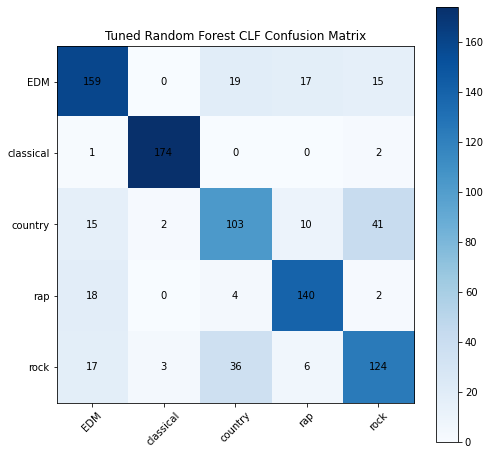

In [128]:
tunedRF = RandomForestClassifier(n_estimators = 1000, max_depth = 90, max_features = 1, min_samples_split = 10, min_samples_leaf=2)

trf_pred_test = runModel(tunedRF, X_train, y_train, X_test)
evalEnv("Random Forest", "Test Set", y_test, trf_pred_test, cm = False)

trf_pred_train = runModel(tunedRF, X_train, y_train, X_train)
evalEnv("Random Forest", "Training Set", y_train, trf_pred_train, cm = False)

trf_pred_val = runModel(tunedRF, X_train, y_train, X_val)
evalEnv("Tuned Random Forest CLF", "Validation Set", y_val, trf_pred_val, cm = True)